In [1]:
import csv
import os
import numpy as np
import h5py
import skimage.io

from glob import glob
img_path_list = glob("CK+48\\*") + glob("fer\\all\\*")
print(img_path_list)

['CK+48\\angry', 'CK+48\\disgust', 'CK+48\\fear', 'CK+48\\happy', 'CK+48\\neutral', 'CK+48\\sad', 'CK+48\\surprise', 'fer\\all\\angry', 'fer\\all\\disgust', 'fer\\all\\fear', 'fer\\all\\happy', 'fer\\all\\neutral', 'fer\\all\\sad', 'fer\\all\\surprise']


In [2]:
# Creat the list to store the data and label information
# train_pixel = []
# train_label = []
# test_pixel = []
# test_label = []
data_pixel = {}
data_label = {}
datapath = os.path.join('data','all_data.npy')
if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

In [3]:
import random
import torch

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)

In [4]:
for i, img_path in enumerate(img_path_list):
    tag = img_path.split("\\")[-1]
    data_pixel.setdefault(tag, [])
    data_label.setdefault(tag, [])
    files = os.listdir(img_path)
    files.sort()
    length = len(files)
    for j, filename in enumerate(files):
        I = skimage.io.imread(os.path.join(img_path,filename))
        data_pixel[tag].append(I.tolist())
        data_label[tag].append(i%7)
        # if j<length*0.8:
        #     train_pixel.append(I.tolist())
        #     train_label.append(i)
        # else:
        #     test_pixel.append(I.tolist())
        #     test_label.append(i)

In [5]:
print(len(data_pixel))
print(len(data_label))

7
7


In [6]:
from PIL import Image
import numpy as np
import h5py
import torch.utils.data as data


class CustomDataset(data.Dataset):
    """
    Args:
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
    """

    def __init__(self, data_pixel, data_label, fold=1, transform=None):
        self.transform = transform
        self.fold = fold  # the k-fold cross validation
        self.data_pixel = data_pixel
        self.data_label = data_label


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = np.array(self.data_pixel[index]), self.data_label[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis=2)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data_pixel)


In [7]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs":256,
    "lr": 0.01,
    "resume": None,
}


best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

path = os.path.join(opt["dataset"] + '_' + opt["model"], str(opt["fold"]))

# Data
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

In [8]:
from sklearn.model_selection import train_test_split, KFold
train_data = []
val_data = []
test_data = []
train_labels = []
val_labels = []
test_labels = []
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3407)
for tag in data_pixel.keys():
    # print("************************************************************************************************")
    X = data_pixel[tag]
    y = data_label[tag]
    # print("X.len= ", len(X))
    for train_val_index, test_index in skf.split(X, y):
        train_val_X, test_X = [X[i] for i in train_val_index], [X[i] for i in test_index]
        train_val_y, test_y = [y[i] for i in train_val_index], [y[i] for i in test_index]
        # print("train_val_X.len= ", len(train_val_X))
        # print("test_X.len= ", len(test_X))

        train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=3407)
        # print("train_X.len= ", len(train_X))
        # print("val_X.len= ", len(val_X))

        # # print(len(train_X))
    for i in train_X:
        train_data.append(i)
    for i in train_y:
        train_labels.append(i)
    for i in val_X:
        val_data.append(i)
    for i in val_y:
        val_labels.append(i)
    for i in test_X:
        test_data.append(i)
    for i in test_y:
        test_labels.append(i)

print(len(train_data))
print(len(val_data))
print(len(test_data))

26544
6640
3684


In [9]:
# def flat(data):
#     return [i for sublist in data for i in sublist]

In [10]:
# train_data = flat(train_data)
# train_labels = flat(train_labels)
# val_data = flat(val_data)
# val_labels = flat(val_labels)
# test_data = flat(test_data)
# test_labels = flat(test_labels)
#
# print(len(train_data))
# print(len(val_data))
# print(len(test_data))

In [11]:

# for train_index, test_index in skf.split(data_pixel, data_label):
#     # print(train_index, test_index)
#     # for i in train_index:
#     #     print(i)
#     train_data, test_data = [data_pixel[i] for i in train_index], [data_pixel[i] for i in test_index]
#     train_labels, test_labels = [data_label[i] for i in train_index], [data_label[i] for i in test_index]

In [12]:
print(len(train_data))
print(len(test_data))

26544
3684


In [13]:
trainset = CustomDataset(fold=opt["fold"], transform=transform_train, data_pixel=train_data, data_label=train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt["train_bs"], shuffle=True)
testset = CustomDataset(fold=opt["fold"], transform=transform_test, data_pixel=test_data, data_label=test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=opt["test_bs"], shuffle=False)
valset = CustomDataset(fold=opt["fold"], transform=transform_test, data_pixel=val_data, data_label=val_labels)
valloader = torch.utils.data.DataLoader(valset, batch_size=opt["val_bs"], shuffle=False)


In [15]:
import dill
# 假设dataloader是要保存的dataloader对象
with open('dataloader\\train.pkl', 'wb') as f:
    dill.dump(trainloader, f)
with open('dataloader\\test.pkl', 'wb') as f:
    dill.dump(testloader, f)
with open('dataloader\\val.pkl', 'wb') as f:
    dill.dump(valloader, f)

In [14]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([64, 3, 44, 44])
torch.Size([64])


E:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


In [15]:
from tqdm import tqdm

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    net.train()
    Train_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = opt["lr"] * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = opt["lr"]
    print('learning_rate: %s' % str(current_lr))

    for inputs, targets in tqdm(trainloader):
        # print(batch_idx, (inputs, targets))
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # print(inputs, targets)
        optimizer.zero_grad()
        # print(optimizer)
        inputs, targets = Variable(inputs), Variable(targets)
        # print(inputs, targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()

        Train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))



    Train_acc = 100. * correct / total
    return Train_loss, Train_acc, current_lr


In [16]:
def test(epoch, all_predicted, all_targets, model_name):
    global Test_acc
    global best_Test_acc
    global best_Test_acc_epoch

    net.eval()
    Test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops

        loss = criterion(outputs_avg, targets)
        Test_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (total_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        if batch_idx == 0:
            temp_all_predicted = predicted
            temp_all_targets = targets
        else:
            temp_all_predicted = torch.cat((temp_all_predicted, predicted), 0)
            temp_all_targets = torch.cat((temp_all_targets, targets), 0)

    # Save checkpoint.
    Test_acc = 100. * correct / total

    if Test_acc > best_Test_acc:
        print('Saving..')
        print("best_Test_acc: %0.3f" % Test_acc)
        state = {'net': net.state_dict() if use_cuda else net,
                 'best_Test_acc': Test_acc,
                 'best_Test_acc_epoch': epoch,
                 }
        if not os.path.isdir(opt["dataset"] + '_' + opt["model"]):
            os.mkdir(opt["dataset"] + '_' + opt["model"])
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path, model_name))
        best_Test_acc = Test_acc
        best_Test_acc_epoch = epoch
        all_predicted = temp_all_predicted
        all_targets = temp_all_targets
        # print("test", all_predicted, all_targets)

    return all_predicted, all_targets, Test_loss, Test_acc


In [17]:
def validate():
    net.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            bs, ncrops, c, h, w = np.shape(inputs)
            inputs = inputs.view(-1, c, h, w)
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
            loss = criterion(outputs_avg, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs_avg.data, 1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets.data).cpu().sum()
            # utils.progress_bar(batch_idx, len(valloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
            #                    % (val_loss / (batch_idx + 1), 100. * val_correct / val_total, val_correct, val_total))
    val_acc = 100. * val_correct / val_total
    return val_loss, val_acc

In [18]:
# Model
# if opt["model"] == 'VGG19':
#     net = VGG('VGG19')
# elif opt["model"] == 'ResNet18':
#     net = ResNet18()


# ResNet101

In [19]:
from models import resnet101
net = resnet101.resnet101(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)

==> Building model..


In [20]:
all_predicted = None
all_targets = None
import wandb
wandb.init(project="Face Expression Recognition", entity="aftermath0703")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted, all_targets=all_targets, model_name="ResNet101.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)

wandb: Currently logged in as: aftermath0703. Use `wandb login --relogin` to force relogin



Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 29.11it/s]
15it [00:03,  4.43it/s]


Saving..
best_Test_acc: 36.564

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.65it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 39.278

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.87it/s]
15it [00:03,  4.48it/s]


Saving..
best_Test_acc: 42.264

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.70it/s]
15it [00:03,  4.52it/s]


Saving..
best_Test_acc: 49.620

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.90it/s]
15it [00:03,  4.50it/s]


Saving..
best_Test_acc: 52.904

Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.91it/s]
15it [00:03,  4.48it/s]



Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.90it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 54.913

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.96it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 55.022

Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.86it/s]
15it [00:03,  4.51it/s]


Saving..
best_Test_acc: 55.293

Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.93it/s]
15it [00:03,  4.52it/s]



Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.88it/s]
15it [00:03,  4.55it/s]


Saving..
best_Test_acc: 55.565

Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.17it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 57.899

Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.95it/s]
15it [00:03,  4.52it/s]


Saving..
best_Test_acc: 59.989

Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.04it/s]
15it [00:03,  4.54it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.94it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 60.043

Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.94it/s]
15it [00:03,  4.54it/s]



Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.03it/s]
15it [00:03,  4.54it/s]



Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.12it/s]
15it [00:03,  4.55it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 35.99it/s]
15it [00:03,  4.55it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.19it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 60.858

Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.24it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 61.971

Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:11<00:00, 36.28it/s]
15it [00:03,  4.39it/s]



Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:11<00:00, 36.25it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 63.626

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:11<00:00, 36.14it/s]
15it [00:03,  4.51it/s]



Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:12<00:00, 32.04it/s]
15it [00:03,  4.56it/s]



Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:11<00:00, 36.20it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 64.034

Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:11<00:00, 36.30it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 66.069

Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:11<00:00, 36.10it/s]
15it [00:03,  4.51it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:11<00:00, 36.24it/s]
15it [00:03,  4.52it/s]



Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:11<00:00, 36.24it/s]
15it [00:03,  4.56it/s]



Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:11<00:00, 36.08it/s]
15it [00:03,  4.50it/s]



Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:11<00:00, 36.22it/s]
15it [00:03,  4.48it/s]


Saving..
best_Test_acc: 66.531

Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:11<00:00, 36.10it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 67.074

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:11<00:00, 35.98it/s]
15it [00:03,  4.51it/s]



Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:11<00:00, 36.14it/s]
15it [00:03,  4.57it/s]



Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:11<00:00, 36.18it/s]
15it [00:03,  4.52it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:11<00:00, 35.67it/s]
15it [00:03,  4.59it/s]


Saving..
best_Test_acc: 67.372

Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:11<00:00, 36.11it/s]
15it [00:03,  4.56it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:11<00:00, 35.88it/s]
15it [00:03,  4.59it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:11<00:00, 36.09it/s]
15it [00:03,  4.56it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:11<00:00, 35.83it/s]
15it [00:03,  4.54it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:11<00:00, 36.09it/s]
15it [00:03,  4.56it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:11<00:00, 35.98it/s]
15it [00:03,  4.52it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:11<00:00, 35.97it/s]
15it [00:03,  4.59it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:11<00:00, 36.08it/s]
15it [00:03,  4.57it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:11<00:00, 35.81it/s]
15it [00:03,  4.50it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:11<00:00, 36.02it/s]
15it [00:03,  4.59it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:11<00:00, 35.49it/s]
15it [00:03,  4.55it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:11<00:00, 36.30it/s]
15it [00:03,  4.56it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:11<00:00, 36.50it/s]
15it [00:03,  4.58it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:11<00:00, 36.43it/s]
15it [00:03,  4.57it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:11<00:00, 36.40it/s]
15it [00:03,  4.56it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:11<00:00, 36.35it/s]
15it [00:03,  4.60it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:11<00:00, 36.53it/s]
15it [00:03,  4.39it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:11<00:00, 36.13it/s]
15it [00:03,  4.60it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:11<00:00, 36.05it/s]
15it [00:03,  4.58it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:11<00:00, 36.06it/s]
15it [00:03,  4.56it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:11<00:00, 36.20it/s]
15it [00:03,  4.59it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:11<00:00, 36.18it/s]
15it [00:03,  4.57it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:11<00:00, 36.02it/s]
15it [00:03,  4.55it/s]

best_Test_acc: 67.372
best_Test_acc_epoch: 36


In [21]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.6  0.   0.09 0.04 0.13 0.12 0.02]
 [0.21 0.67 0.04 0.01 0.01 0.03 0.03]
 [0.09 0.   0.52 0.03 0.12 0.16 0.07]
 [0.01 0.   0.02 0.87 0.06 0.03 0.01]
 [0.07 0.   0.05 0.08 0.63 0.15 0.02]
 [0.1  0.   0.13 0.06 0.17 0.53 0.01]
 [0.03 0.   0.09 0.05 0.03 0.02 0.79]]


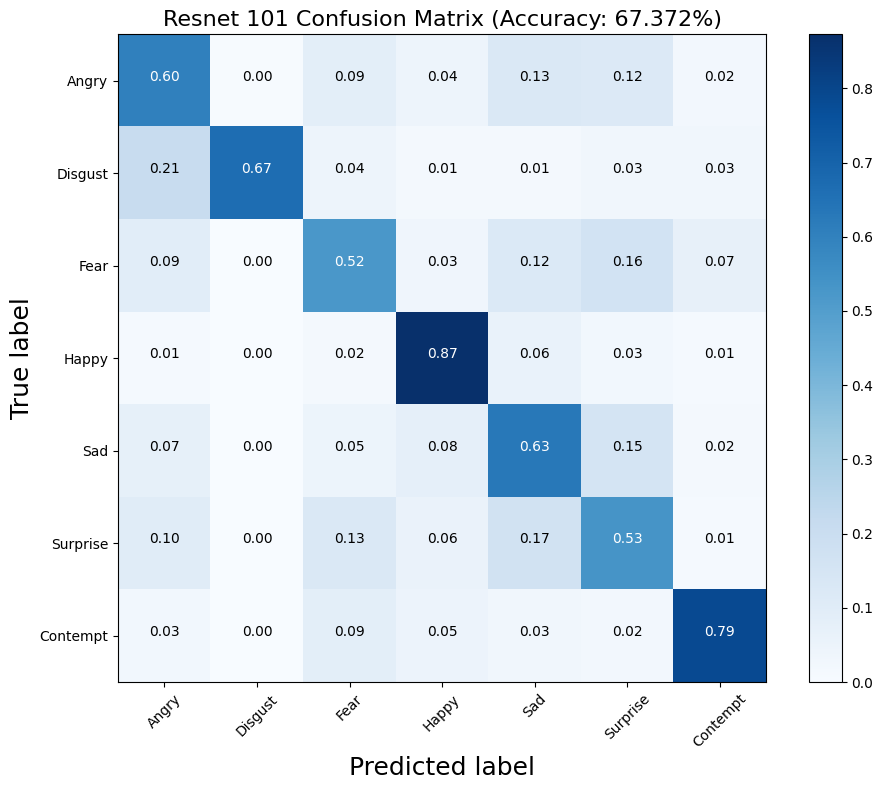

In [22]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='Resnet 101 Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet Confusion Matrix.png'))
plt.close()

In [23]:
wandb.finish()

Learning Rate,██████████████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Acc,▁▂▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇███████████████████
Test Loss,██▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Train Acc,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████████████████
Train Loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
Test Acc,66.58524
Test Loss,17.6976
Train Acc,92.08861
Train Loss,95.40036


In [24]:
net

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [25]:
import gc

del net
gc.collect

<function gc.collect(generation=2)>

# Resnet101 + SE Attention

In [26]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs":256,
    "lr": 0.01,
    "resume": None,
}


best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

In [27]:
from models import SEAttention
net = SEAttention.resnet101_SE_attention(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)



==> Building model..


In [28]:
net

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se_attention): SEAttentionBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()


In [29]:
all_predicted = None
all_targets = None
import wandb
wandb.init(project="Face Expression Recognition", entity="aftermath0703")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted, all_targets=all_targets, model_name="ResNet101 SE Attention.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)
wandb.finish()


Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.60it/s]
15it [00:03,  4.61it/s]


Saving..
best_Test_acc: 38.111

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.84it/s]
15it [00:03,  4.57it/s]


Saving..
best_Test_acc: 42.427

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.95it/s]
15it [00:03,  4.55it/s]


Saving..
best_Test_acc: 42.915

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.91it/s]
15it [00:03,  4.54it/s]



Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.91it/s]
15it [00:03,  4.57it/s]


Saving..
best_Test_acc: 52.226

Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.84it/s]
15it [00:03,  4.55it/s]


Saving..
best_Test_acc: 56.895

Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.75it/s]
15it [00:03,  4.56it/s]



Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.71it/s]
15it [00:03,  4.57it/s]



Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.93it/s]
15it [00:03,  4.55it/s]


Saving..
best_Test_acc: 58.170

Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.05it/s]
15it [00:03,  4.61it/s]



Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.02it/s]
15it [00:03,  4.46it/s]


Saving..
best_Test_acc: 59.501

Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.39it/s]
15it [00:03,  4.47it/s]



Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.43it/s]
15it [00:03,  4.51it/s]


Saving..
best_Test_acc: 60.288

Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.69it/s]
15it [00:03,  4.61it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.87it/s]
15it [00:03,  4.60it/s]


Saving..
best_Test_acc: 60.776

Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.73it/s]
15it [00:03,  4.56it/s]



Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.87it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 60.803

Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.94it/s]
15it [00:03,  4.53it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.81it/s]
15it [00:03,  4.58it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.56it/s]
15it [00:03,  4.57it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.08it/s]
15it [00:03,  4.12it/s]


Saving..
best_Test_acc: 61.672

Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:31<00:00, 13.25it/s]
15it [00:06,  2.29it/s]



Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:31<00:00, 13.17it/s]
15it [00:07,  2.02it/s]


Saving..
best_Test_acc: 62.514

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:31<00:00, 13.23it/s]
15it [00:07,  2.09it/s]


Saving..
best_Test_acc: 64.658

Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:23<00:00, 17.37it/s]
15it [00:03,  4.49it/s]


Saving..
best_Test_acc: 65.527

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:15<00:00, 27.67it/s]
15it [00:03,  4.55it/s]


Saving..
best_Test_acc: 65.662

Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:14<00:00, 27.69it/s]
15it [00:03,  4.47it/s]


Saving..
best_Test_acc: 65.879

Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:14<00:00, 27.80it/s]
15it [00:03,  4.52it/s]


Saving..
best_Test_acc: 66.151

Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:14<00:00, 27.86it/s]
15it [00:03,  4.50it/s]


Saving..
best_Test_acc: 66.314

Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:14<00:00, 27.81it/s]
15it [00:03,  4.52it/s]


Saving..
best_Test_acc: 66.477

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:14<00:00, 27.83it/s]
15it [00:03,  4.59it/s]


Saving..
best_Test_acc: 66.640

Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:14<00:00, 27.80it/s]
15it [00:03,  4.55it/s]



Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:14<00:00, 27.77it/s]
15it [00:03,  4.53it/s]


Saving..
best_Test_acc: 66.748

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:15<00:00, 27.37it/s]
15it [00:03,  4.63it/s]



Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:14<00:00, 28.32it/s]
15it [00:03,  4.58it/s]


Saving..
best_Test_acc: 66.802

Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:14<00:00, 28.12it/s]
15it [00:03,  4.63it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:14<00:00, 28.30it/s]
15it [00:03,  4.63it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:14<00:00, 28.21it/s]
15it [00:03,  4.61it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:14<00:00, 28.27it/s]
15it [00:03,  4.56it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:14<00:00, 28.35it/s]
15it [00:03,  4.59it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:14<00:00, 28.28it/s]
15it [00:03,  4.62it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:14<00:00, 28.30it/s]
15it [00:03,  4.61it/s]


Saving..
best_Test_acc: 67.047

Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:14<00:00, 28.27it/s]
15it [00:03,  4.57it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:14<00:00, 28.25it/s]
15it [00:03,  4.61it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:14<00:00, 28.16it/s]
15it [00:03,  4.64it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:14<00:00, 28.15it/s]
15it [00:03,  4.64it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:14<00:00, 28.11it/s]
15it [00:03,  4.63it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:14<00:00, 28.00it/s]
15it [00:03,  4.58it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:14<00:00, 28.04it/s]
15it [00:03,  4.58it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:14<00:00, 28.13it/s]
15it [00:03,  4.63it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:14<00:00, 27.99it/s]
15it [00:03,  4.60it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:14<00:00, 28.08it/s]
15it [00:03,  4.61it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:14<00:00, 27.98it/s]
15it [00:03,  4.57it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:14<00:00, 28.15it/s]
15it [00:03,  4.58it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:14<00:00, 28.02it/s]
15it [00:03,  4.60it/s]


Saving..
best_Test_acc: 67.074

Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:14<00:00, 28.11it/s]
15it [00:03,  4.61it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:14<00:00, 27.94it/s]
15it [00:03,  4.59it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:14<00:00, 28.05it/s]
15it [00:03,  4.60it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:16<00:00, 25.67it/s]
15it [00:04,  3.00it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:31<00:00, 13.00it/s]
15it [00:07,  2.09it/s]

best_Test_acc: 67.074
best_Test_acc_epoch: 54


Learning Rate,██████████████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Acc,▁▂▂▄▄▅▅▆▆▆▆▆▆▆▆▇████████████████████████
Test Loss,█▇▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃
Train Acc,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇██████████████████
Train Loss,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
Test Acc,66.7481
Test Loss,17.77351
Train Acc,94.76341
Train Loss,64.88736


In [30]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.61 0.   0.09 0.04 0.1  0.13 0.02]
 [0.17 0.68 0.03 0.03 0.03 0.04 0.03]
 [0.1  0.   0.49 0.03 0.09 0.21 0.08]
 [0.02 0.   0.01 0.86 0.06 0.04 0.01]
 [0.08 0.   0.06 0.08 0.61 0.16 0.02]
 [0.11 0.   0.12 0.05 0.15 0.56 0.01]
 [0.04 0.   0.08 0.04 0.03 0.02 0.79]]


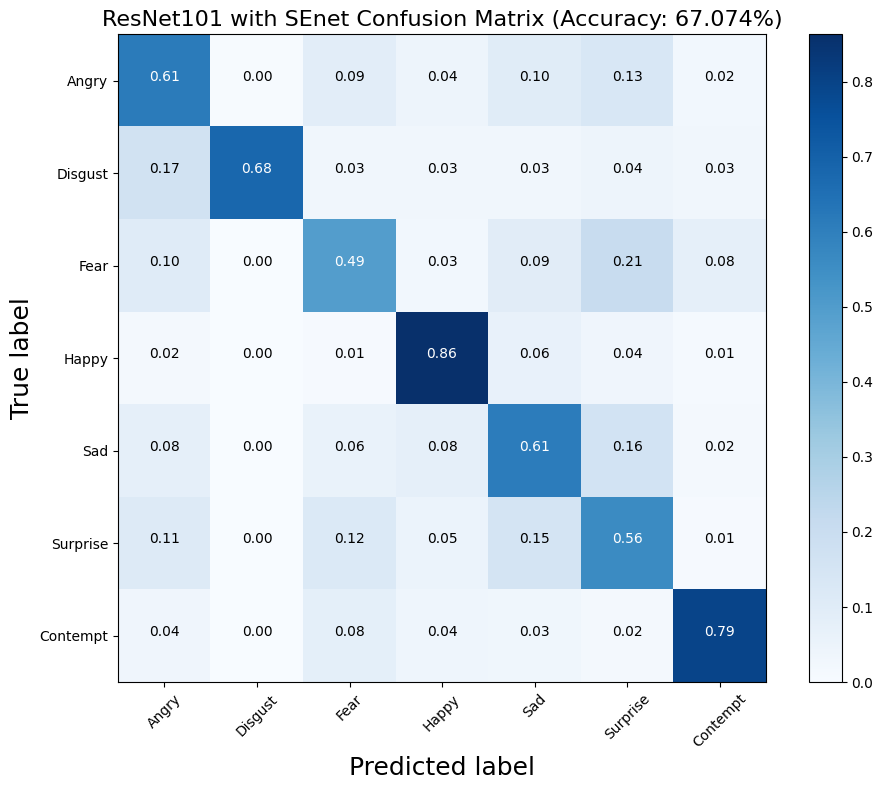

In [31]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with SEnet Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with SEnet Confusion Matrix.png'))
plt.close()

In [32]:
import gc

del net
gc.collect

<function gc.collect(generation=2)>

# 自注意力机制(transformer encode部分)

In [33]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs":256,
    "lr": 0.01,
    "resume": None,
}


best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

In [34]:
import gc

del net
gc.collect()

NameError: name 'net' is not defined

In [35]:
from models import SelfAttention

net = SelfAttention.resnet101_self_attention(num_classes=7)
net

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SelfBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (self_attention): SelfAttentionBlock(
        (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
        (key_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
        (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (shortcut): Identity()
    )
    (1): 

In [36]:

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


==> Building model..


In [37]:
all_predicted = None
all_targets = None
import wandb
wandb.init(project="Face Expression Recognition", entity="aftermath0703")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted, all_targets=all_targets, model_name="ResNet101 SelfAttention.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)
wandb.finish()


Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.04it/s]
15it [00:03,  4.09it/s]


Saving..
best_Test_acc: 30.130

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.31it/s]
15it [00:03,  4.11it/s]


Saving..
best_Test_acc: 41.694

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.36it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 48.453

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.20it/s]
15it [00:03,  4.11it/s]


Saving..
best_Test_acc: 52.117

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.20it/s]
15it [00:03,  4.12it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.30it/s]
15it [00:03,  4.11it/s]



Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 55.945

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.40it/s]
15it [00:03,  4.09it/s]



Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.51it/s]
15it [00:03,  4.17it/s]



Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.33it/s]
15it [00:03,  4.14it/s]


Saving..
best_Test_acc: 57.953

Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.42it/s]
15it [00:03,  4.17it/s]


Saving..
best_Test_acc: 60.478

Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:20<00:00, 20.64it/s]
15it [00:03,  4.13it/s]



Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.34it/s]
15it [00:03,  4.11it/s]



Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.31it/s]
15it [00:03,  4.15it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.34it/s]
15it [00:03,  4.11it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.41it/s]
15it [00:03,  4.14it/s]


Saving..
best_Test_acc: 60.858

Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.26it/s]
15it [00:03,  4.09it/s]


Saving..
best_Test_acc: 62.432

Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.30it/s]
15it [00:03,  4.13it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.19it/s]
15it [00:03,  4.15it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.31it/s]
15it [00:03,  4.12it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.37it/s]
15it [00:03,  4.16it/s]



Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:19<00:00, 21.30it/s]
15it [00:03,  4.11it/s]


Saving..
best_Test_acc: 63.545

Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:19<00:00, 21.24it/s]
15it [00:03,  4.12it/s]



Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.17it/s]


Saving..
best_Test_acc: 63.599

Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:19<00:00, 21.27it/s]
15it [00:03,  4.17it/s]


Saving..
best_Test_acc: 64.875

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:19<00:00, 21.32it/s]
15it [00:03,  4.15it/s]



Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:19<00:00, 21.18it/s]
15it [00:03,  4.17it/s]


Saving..
best_Test_acc: 65.907

Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:19<00:00, 21.38it/s]
15it [00:03,  4.18it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:19<00:00, 21.43it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 66.097

Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:19<00:00, 21.34it/s]
15it [00:03,  4.14it/s]


Saving..
best_Test_acc: 66.558

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:19<00:00, 21.38it/s]
15it [00:03,  4.16it/s]



Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:19<00:00, 21.36it/s]
15it [00:03,  4.14it/s]


Saving..
best_Test_acc: 66.640

Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:19<00:00, 20.99it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 67.182

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:19<00:00, 21.41it/s]
15it [00:03,  4.12it/s]


Saving..
best_Test_acc: 67.264

Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:19<00:00, 21.36it/s]
15it [00:03,  4.15it/s]



Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:20<00:00, 20.42it/s]
15it [00:03,  4.18it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:19<00:00, 21.61it/s]
15it [00:03,  4.20it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:19<00:00, 21.45it/s]
15it [00:03,  4.16it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:19<00:00, 21.53it/s]
15it [00:03,  4.12it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:19<00:00, 21.38it/s]
15it [00:03,  4.08it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.12it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:19<00:00, 21.37it/s]
15it [00:03,  4.12it/s]


Saving..
best_Test_acc: 67.318

Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.12it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:19<00:00, 21.34it/s]
15it [00:03,  4.14it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:19<00:00, 21.34it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 67.725

Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.15it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:19<00:00, 21.28it/s]
15it [00:03,  4.17it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:19<00:00, 21.28it/s]
15it [00:03,  4.17it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:19<00:00, 21.26it/s]
15it [00:03,  4.17it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:19<00:00, 21.37it/s]
15it [00:03,  3.87it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:19<00:00, 21.26it/s]
15it [00:03,  4.11it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:19<00:00, 21.23it/s]
15it [00:03,  4.18it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:19<00:00, 21.27it/s]
15it [00:03,  4.09it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:19<00:00, 21.35it/s]
15it [00:03,  4.18it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:19<00:00, 20.84it/s]
15it [00:03,  4.15it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:19<00:00, 21.29it/s]
15it [00:03,  4.09it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:19<00:00, 21.29it/s]
15it [00:03,  4.17it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:19<00:00, 21.28it/s]
15it [00:03,  4.11it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:19<00:00, 21.29it/s]
15it [00:03,  4.17it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:19<00:00, 21.53it/s]
15it [00:03,  4.15it/s]

best_Test_acc: 67.725
best_Test_acc_epoch: 44


Learning Rate,██████████████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Acc,▁▃▅▁▆▆▆▇▆▇▇▇▆▇▇▇▇▇██████████████████████
Test Loss,█▅▄█▃▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃
Train Acc,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇████████████████
Train Loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
Test Acc,67.61672
Test Loss,17.04598
Train Acc,92.63864
Train Loss,87.87099


Normalized confusion matrix
[[0.64 0.   0.07 0.05 0.12 0.1  0.02]
 [0.21 0.62 0.07 0.   0.01 0.07 0.01]
 [0.12 0.   0.48 0.03 0.11 0.19 0.08]
 [0.03 0.   0.01 0.86 0.06 0.03 0.01]
 [0.08 0.   0.04 0.07 0.62 0.17 0.02]
 [0.1  0.   0.13 0.04 0.14 0.57 0.01]
 [0.03 0.   0.07 0.04 0.03 0.02 0.81]]


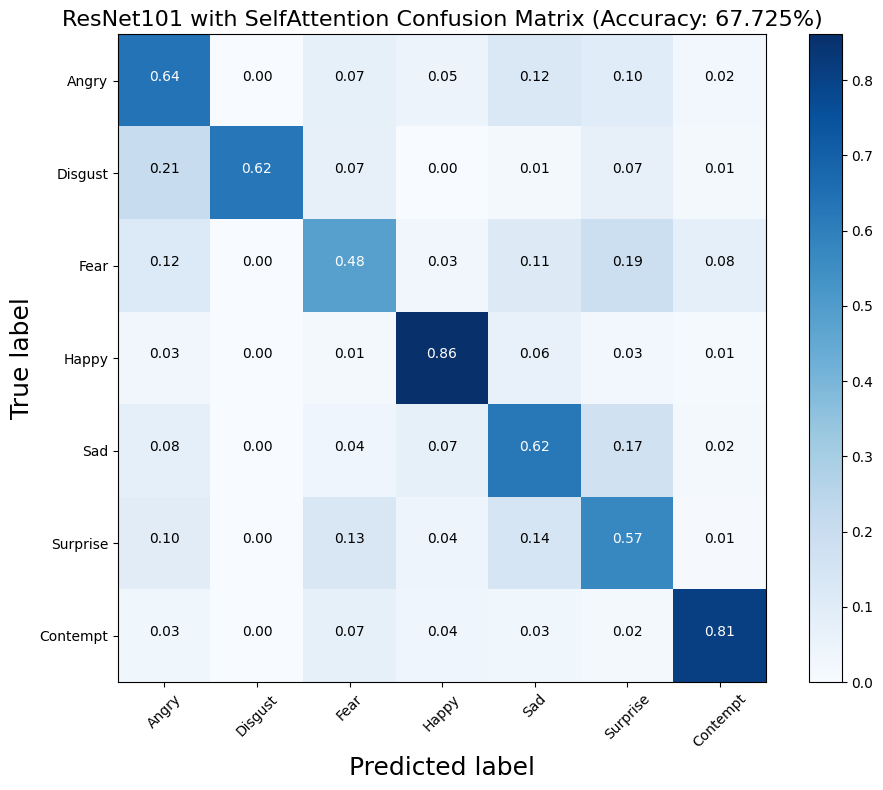

In [38]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with SelfAttention Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with SelfAttention Confusion Matrix.png'))
plt.close()

# BAM

In [39]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs": 256,
    "lr": 0.01,
    "resume": None,
}

best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

In [40]:
import gc

del net
gc.collect()

9329

In [54]:
from models import BAMAttention

net = BAMAttention.resnet101_BAM_attention(7)

In [55]:
net

In [56]:
if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


In [51]:
all_predicted = None
all_targets = None
import wandb

wandb.init(project="Face Expression Recognition", entity="aftermath0703")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted,
                                                           all_targets=all_targets,
                                                           model_name="ResNet101 SelfAttention.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)
wandb.finish()

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with SelfAttention Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with SelfAttention Confusion Matrix.png'))
plt.close()